In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import seaborn as sns
from matplotlib.dates import date2num
import plotly.graph_objs as go
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from keras.models import Sequential
from keras.layers import Dense, LSTM

2024-06-17 15:29:50.932722: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-17 15:29:50.932872: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-17 15:29:51.104612: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
def NSE(y_test, y_pred):
    return (1 - (np.sum((y_pred - y_test) ** 2) / np.sum((y_test - np.mean(y_test)) ** 2)))

def R2(y_test, y_pred):
    y_test_mean = np.mean(y_test)
    #print(y_test_mean)
    y_pred_mean = np.mean(y_pred)
    #print(y_pred_mean)
    S_res = np.sum((y_test - y_test_mean)*(y_pred - y_pred_mean))
    #print(S_res)
    S_tot1 = np.sum((y_test - y_test_mean)**2)
    #print(S_tot1)
    S_tot2 = np.sum((y_pred - y_pred_mean)**2)
    #print(S_tot2)
    S_tot = np.sqrt(S_tot1 * S_tot2)
    #print(S_tot1 * S_tot2, S_tot)
    return (S_res / S_tot) ** 2

def MAE(y_test, y_pred):
    return mean_absolute_error(y_test, y_pred)

def RMSE(y_test, y_pred):
    return mean_squared_error(y_test, y_pred, squared=False)

In [13]:
vcb = pd.read_csv(r"/kaggle/input/datavcb/vcb_2010-2024.csv")
vcb['DATE'] = pd.to_datetime(vcb['DATE'], dayfirst= True)
vcb = vcb[::-1].reset_index(drop=True)
vcb.set_index('DATE', inplace=True)
vcb.head(10)

/tmp/ipykernel_33/2321477923.py:2: UserWarning: Parsing dates in %m/%d/%Y format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  vcb['DATE'] = pd.to_datetime(vcb['DATE'], dayfirst= True)


,OPEN,HIGH,LOW,CLOSE,VOLUMN
DATE,,,,,
2010-01-04,13842,14519,13842,14519,2032674
2010-01-05,15020,15167,14519,14667,3175256
2010-01-06,14166,14667,14136,14136,1629290
2010-01-07,14136,14166,13842,13842,704530
2010-01-08,14019,14078,13812,13842,1193887
2010-01-11,13989,13989,13194,13842,703273
2010-01-12,13695,13842,13400,13400,915355
2010-01-13,12811,13842,12811,13842,1594215
2010-01-14,13842,13901,13547,13665,440021


In [4]:
data = vcb.filter(['CLOSE'])
dataset = data.values

training_data_len = int(np.ceil( len(dataset) * 0.8 ))
training_data_len

2874

In [5]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

In [6]:
train_data = scaled_data[0:int(training_data_len), :]
# Split the data
x_train = []
y_train = []
#chia 60 diem du lieu va x train
# diem du lieu thu 61 vao y train
# hoc tu 60 diem du lieu truoc
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()

# Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


[array([0.06988149, 0.0715424 , 0.06558334, 0.06228397, 0.06228397,
       0.06228397, 0.0573237 , 0.06228397, 0.06029762, 0.05666158,
       0.05071374, 0.05468645, 0.05170131, 0.04906406, 0.04741437,
       0.04741437, 0.04840194, 0.04840194, 0.04675226, 0.04575347,
       0.04509135, 0.04675226, 0.05071374, 0.05402433, 0.05137586,
       0.05137586, 0.04773982, 0.05071374, 0.05402433, 0.05402433,
       0.05633613, 0.05633613, 0.06063429, 0.06228397, 0.06889393,
       0.0715424 , 0.06360821, 0.06493244, 0.06260942, 0.0619473 ,
       0.0619473 , 0.06558334, 0.06525789, 0.06393365, 0.06393365,
       0.06228397, 0.05831126, 0.05567401, 0.05599946, 0.05434978,
       0.0550119 , 0.05533734, 0.05633613, 0.05302554, 0.0573237 ,
       0.05533734, 0.05302554, 0.05236342, 0.05302554, 0.05336221])]
[0.05468644790591193]

[array([0.06988149, 0.0715424 , 0.06558334, 0.06228397, 0.06228397,
       0.06228397, 0.0573237 , 0.06228397, 0.06029762, 0.05666158,
       0.05071374, 0.05468645, 0.05

In [7]:
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K
class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name="att_weight",shape=(input_shape[-1],1),initializer="normal")
        self.b=self.add_weight(name="att_bias",shape=(input_shape[1],1),initializer="zeros")
        super(attention, self).build(input_shape)

    def call(self,x):
        et=K.squeeze(K.tanh(K.dot(x,self.W)+self.b),axis=-1)
        at=K.softmax(et)
        at=K.expand_dims(at,axis=-1)
        output=x*at
        return K.sum(output,axis=1)

    def compute_output_shape(self,input_shape):
        return (input_shape[0],input_shape[-1])

    def get_config(self):
        return super(attention,self).get_config()

In [8]:
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, RepeatVector
from tensorflow.keras.models import Sequential

model = Sequential()
model.add(Bidirectional(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], 1))))
model.add(attention())
model.add(RepeatVector(x_train.shape[1]))
model.add(Bidirectional(LSTM(64, return_sequences=False)))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size=16, epochs=10)


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 20s 73ms/step - loss: 0.0088
Epoch 2/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 12s 70ms/step - loss: 0.0011
Epoch 3/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 14s 78ms/step - loss: 9.5056e-04
Epoch 4/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 13s 72ms/step - loss: 8.7449e-04
Epoch 5/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 12s 69ms/step - loss: 8.0052e-04
Epoch 6/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 13s 72ms/step - loss: 7.9575e-04
Epoch 7/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 12s 70ms/step - loss: 7.3438e-04
Epoch 8/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 13s 72ms/step - loss: 6.4512e-04
Epoch 9/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 12s 70ms/step - loss: 5.4013e-04
Epoch 10/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 12s 70ms/step - loss: 4.5270e-04


In [9]:

test_data = scaled_data[training_data_len - 60: , :]
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

r2 = R2(y_test, predictions)
nse = NSE(y_test, predictions)
mae = MAE(y_test, predictions)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
print("R2: ", r2)
print("NSE: ", nse)
print("MAE: ", mae)
print("RMSE: ", rmse)


23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step
R2:  0.9499569269498501
NSE:  0.9486156284542654
MAE:  1842.8497018628134
RMSE:  2479.716040129308


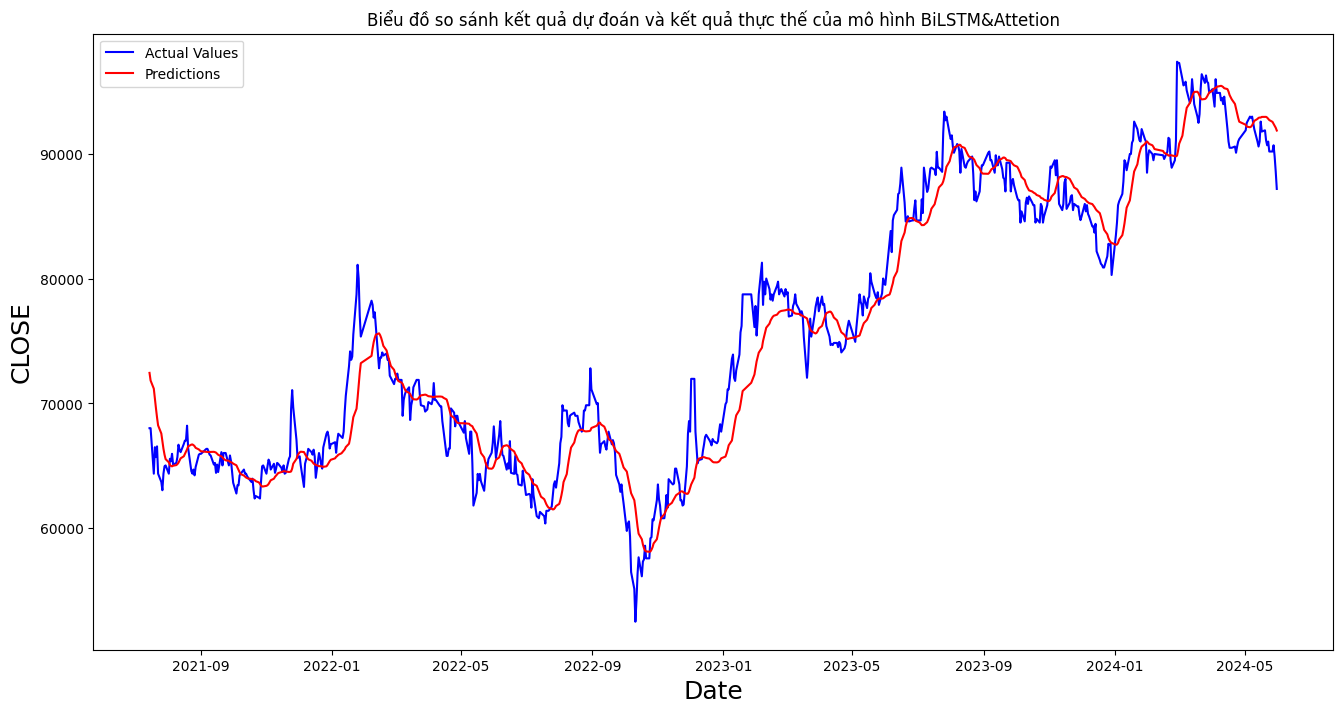

In [14]:
train = data[training_data_len:]

valid = data[training_data_len:].copy()
valid['Predictions'] = predictions

plt.figure(figsize=(16, 8))
plt.title('Biểu đồ so sánh kết quả dự đoán và kết quả thực thế của mô hình BiLSTM&Attetion')
plt.xlabel('Date', fontsize=18)
plt.ylabel('CLOSE', fontsize=18)

# Plot actual values
plt.plot(valid.index, valid['CLOSE'], label='Actual Values', color='blue')
plt.plot(valid.index, valid['Predictions'], label='Predictions', color='red')
plt.legend(loc='upper left')
plt.show()